In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage import draw
import csv

In [2]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Sat, 01 Apr 2023 18:12:54] [INFO    ] [topostats] Extracting image from PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm
[Sat, 01 Apr 2023 18:12:54] [INFO    ] [topostats] Loading image from : PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm
[Sat, 01 Apr 2023 18:12:54] [INFO    ] [topostats] [20230125_KPN005_25mMMgCl2_Vac.0_00009] : Loaded image from : PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm
[Sat, 01 Apr 2023 18:12:54] [INFO    ] [topostats] [20230125_KPN005_25mMMgCl2_Vac.0_00009] : Extracted channel Height
[Sat, 01 Apr 2023 18:12:54] [INFO    ] [topostats] [20230125_KPN005_25mMMgCl2_Vac.0_00009] : Pixel to nm scaling : 2.67421875


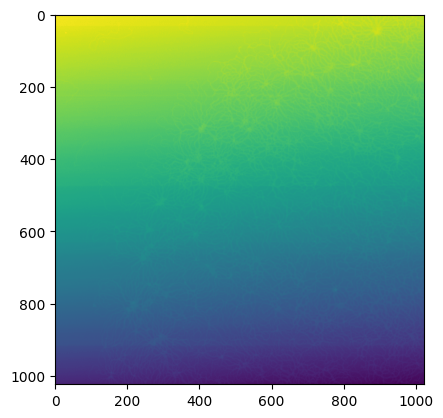

In [3]:
    #Zoom
file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00009.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [4]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sat, 01 Apr 2023 18:12:55] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Median flattening without mask
[Sat, 01 Apr 2023 18:12:56] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Plane tilt removal without mask
[Sat, 01 Apr 2023 18:12:56] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : x-polyfit 1st order: [-0.00531255  2.59373902]
[Sat, 01 Apr 2023 18:12:56] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : y-polyfit 1st order: [ 7.64712662e-19 -5.85439556e-16]
[Sat, 01 Apr 2023 18:12:56] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Removing x plane tilt
[Sat, 01 Apr 2023 18:12:57] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : removing y plane tilt
[Sat, 01 Apr 2023 18:12:58] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Remove quadratic bow 

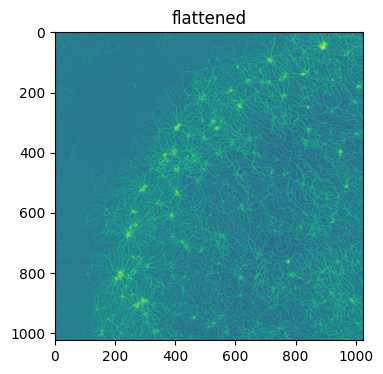

In [5]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(4,4))

thresholds: defaultdict(None, {'upper': 1.8692188728327763})
[Sat, 01 Apr 2023 18:13:07] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.8692188728327763


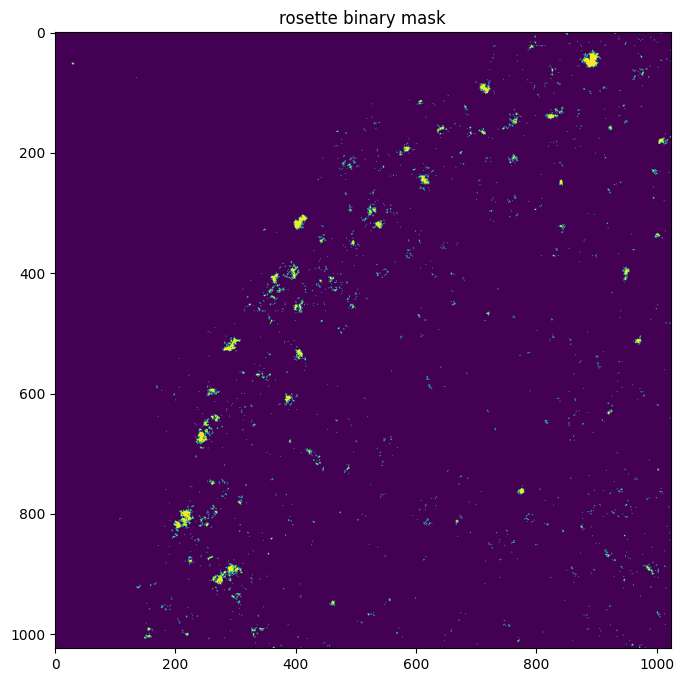

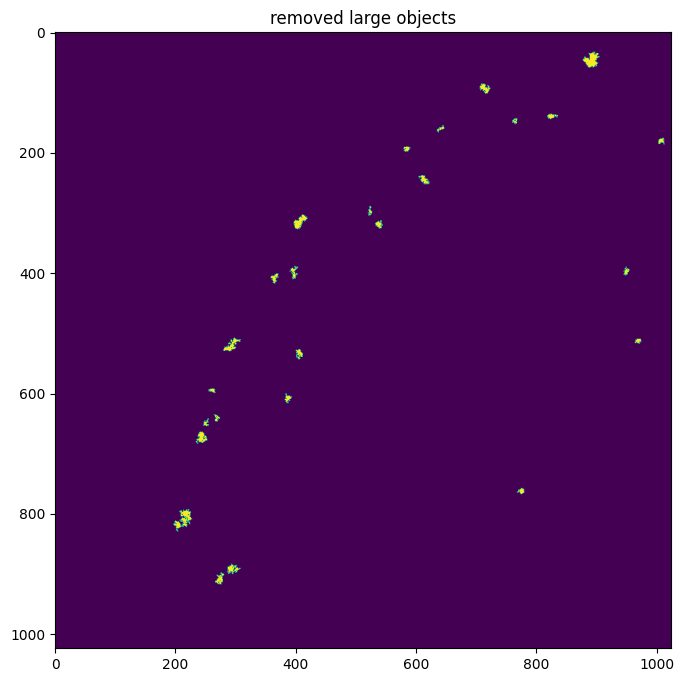

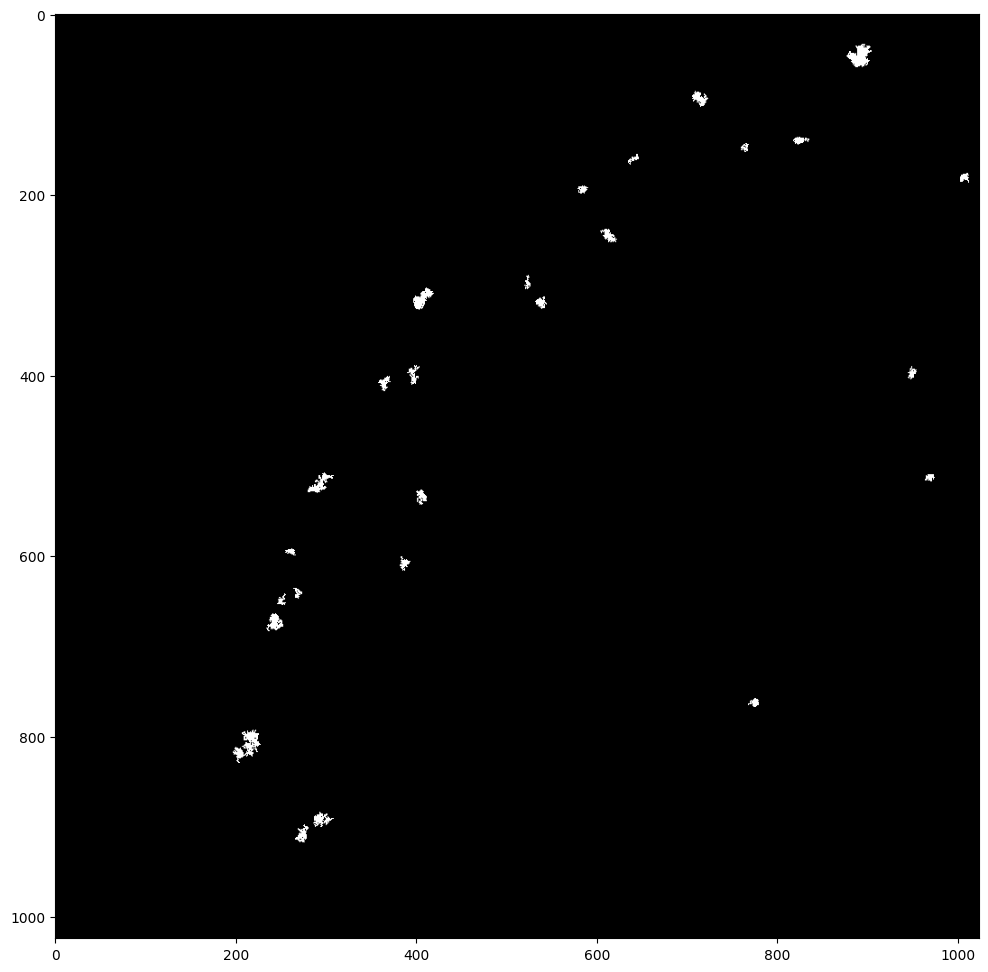

In [6]:
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 3, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 50)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


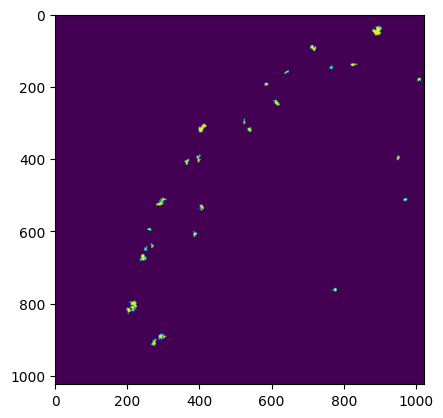

In [7]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()


# # Find centroids of remaining points
# labelled = label(node_points)
# regions = regionprops(labelled)
# centroids = np.ndarray((len(regions), 2))
# for props_index, props in enumerate(regions):
#     centroids[props_index, :] = (props.centroid[0],props.centroid[1])
# centroids = np.vstack((centroids,(200,200)))
# #centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])
# print(centroids)

import network_stats
#from network_stats import get_node_centroids
dir(network_stats)

node_centroids = network_stats.get_node_centroids(labelled_rosette_mask)

Out of bounds
Average:coordination 0.76
Peak Areas: [[0], [], [0], [0], [], [0], [0], [0], [0], [], [0], [0], [0], [], [], [0], [0], [], [0], [0], [0], [0], [0], [0], [0]]


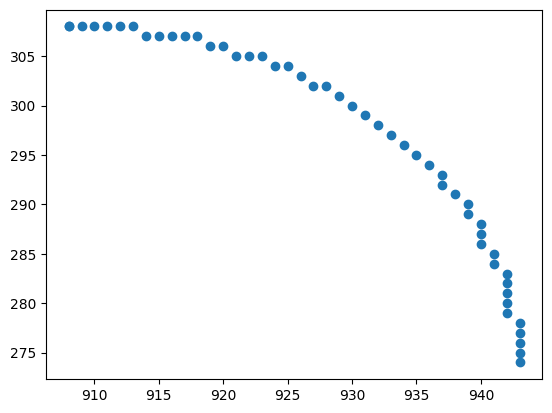

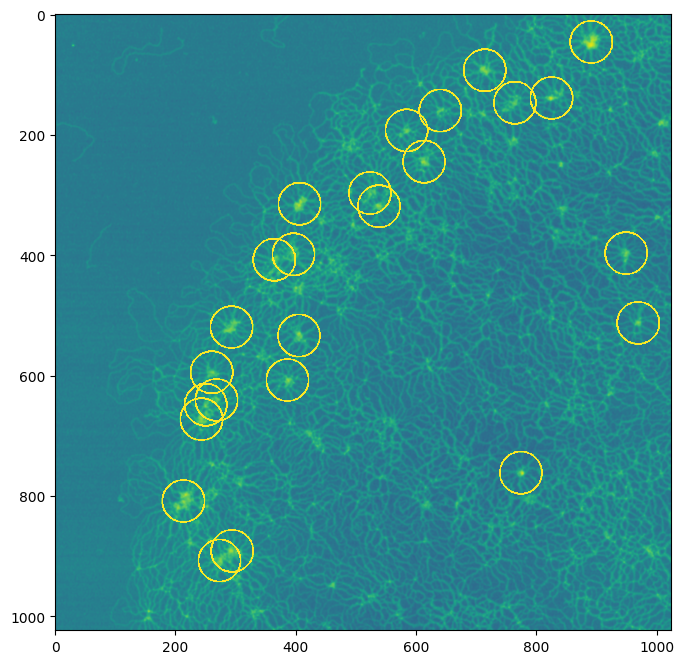

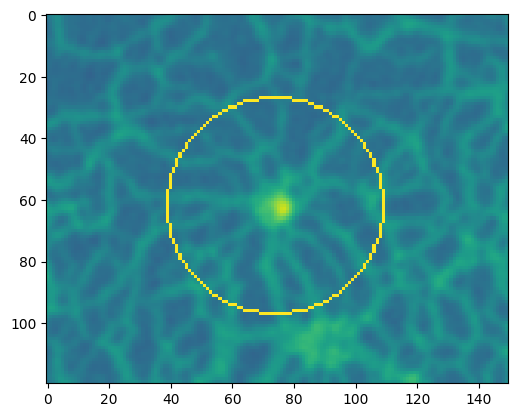

In [8]:
#Create circular masks around each nodes and extract heights
circle_mask = gaussian(flattened.copy(), sigma=1.0)
circle_image = gaussian(flattened.copy(), sigma=1.0)
radius =  35
circ_nm = 45*2*np.pi*p_to_nm
region_values,included,area_tot,counts,region_peakarea = [],[],[],[],[]

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)


for centroid in node_centroids:
    rr,cc = draw.circle_perimeter(int(centroid[0]), int(centroid[1]), radius, method='bresenham')
    inc_nm = circ_nm/len(rr)
    background = 0.75
    if any((i<0 or i>1024) for i in rr) or any((j<0 or j>1024) for j in cc):
        print("Out of bounds")
    else:  
        #separates rr,cc into XY pairs
        XY = [i for i in zip(rr,cc)]
        # Sort the points based on their angles around the centroid
        indices = ((np.argsort([angle(point, centroid) for point in XY])))
        sorted,rr_sort,cc_sort = [],[],[]
        for i in indices:
            sorted.append(XY[i])
        for j in sorted:
            rr_sort.append(j[0])
            cc_sort.append(j[1])

        perimeter_values = circle_mask[rr_sort,cc_sort]
        #perimeter_values = np.clip(circle_mask[rr_sort,cc_sort]-background,0,1000)
        prev,count,trparea = 0,0,0
        peak_area = []
        for height in perimeter_values:
            if height > 0 and prev == 0:
                peak_area.append(trparea)
            elif height > 0 and prev > 0:
                trparea = 0.5*(height-prev)*inc_nm + prev*inc_nm
            prev = height
        count = len(peak_area)
        counts.append(count)
        region_peakarea.append(peak_area)
        region_values.append(perimeter_values)
        circle_image[rr_sort,cc_sort] = 100
        area_tot = np.trapz(region_values,dx=5)
        #print("Area:",area_tot)
        #plt.text(point[0],point[1],"1",fontsize=1)

print("Average:coordination",(sum(counts)/len(counts)))
print("Peak Areas:",region_peakarea)
plt.scatter(rr_sort[0:50],cc_sort[0:50])
plt.show
plot(circle_image)
plt.show()
subsection = circle_image[700:820, 700:850]
plt.imshow(subsection, vmin=-3, vmax=4)
plt.show()

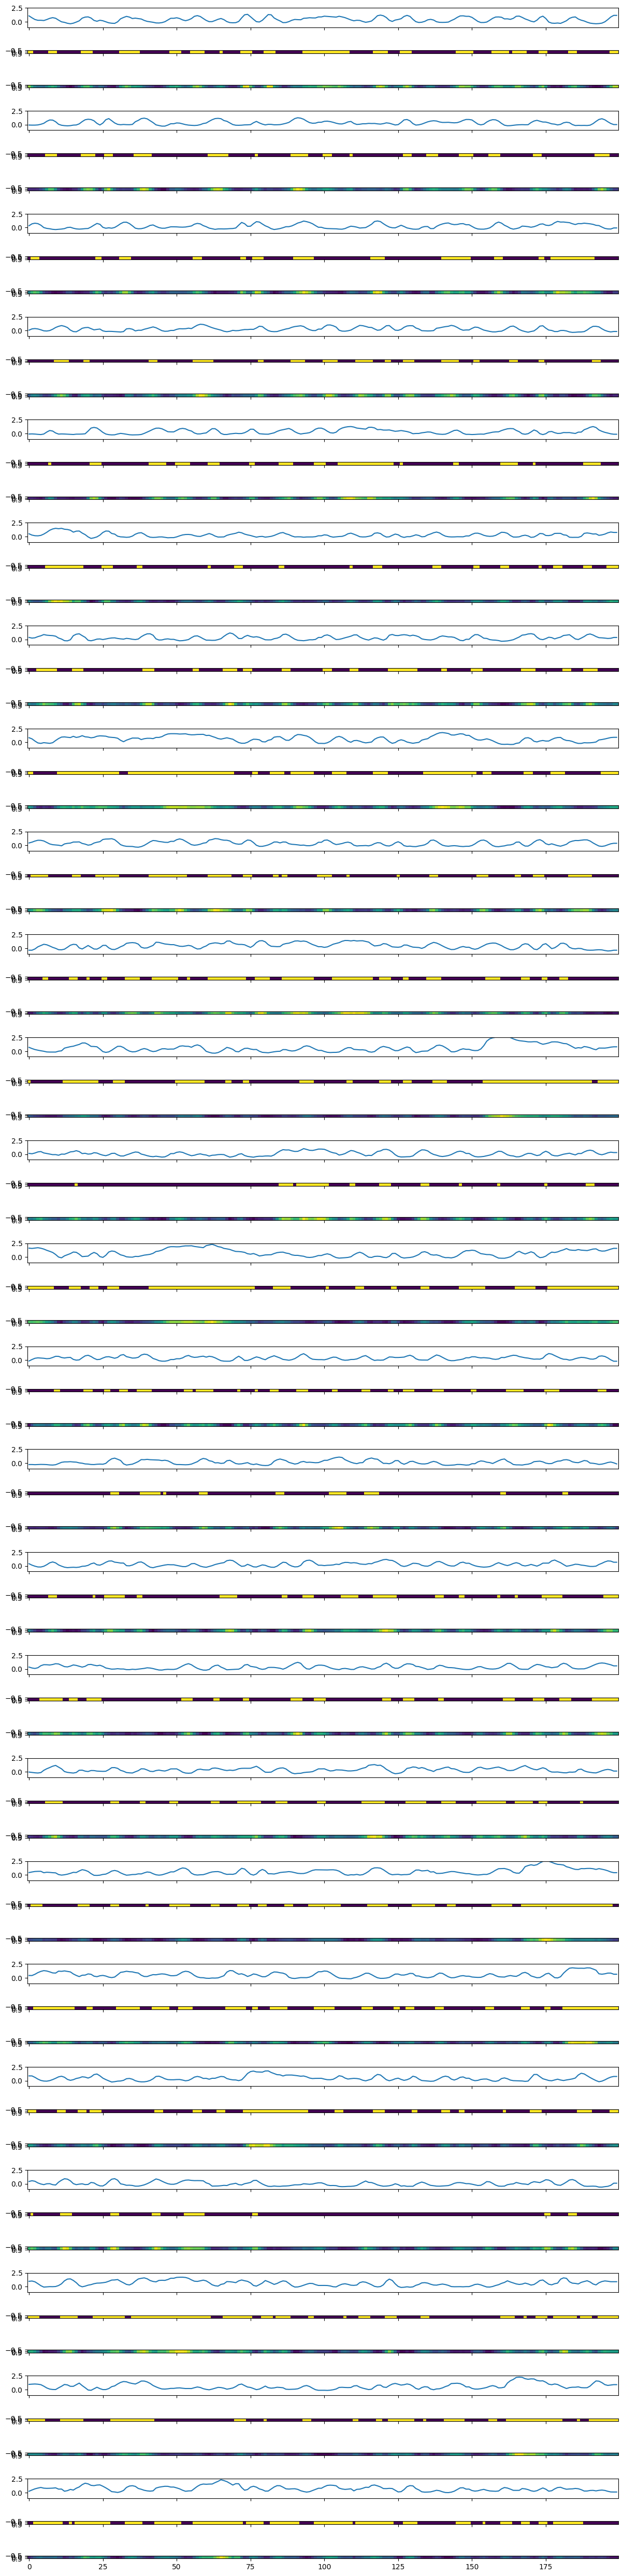

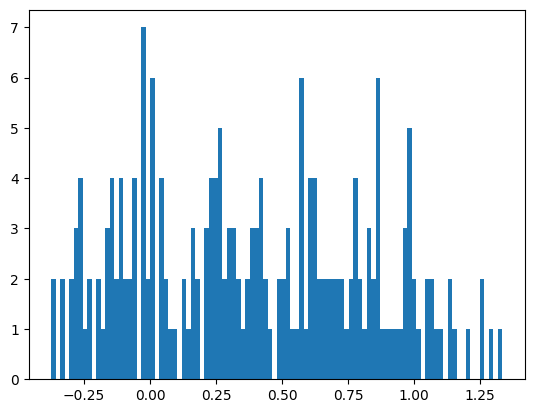

In [9]:
fig, ax = plt.subplots(len(region_values*3),1,figsize=(12, 50), sharex=True)
fig.tight_layout()
for i, values in enumerate(region_values):
    ax[i*3].set_ylim(-1, 2.5)
    ax[i*3].plot(values)
    ax[i*3+2].imshow([values])
    ax[i*3+1].imshow(np.array([values > 0.5]))
plt.show()
index = 0
values = region_values[index]
fig, ax = plt.subplots()
ax.hist(values, bins=100)
plt.show()

# fig, ax = plt.subplots(len(region_values),1,figsize=(100, 12))
# for i, values in enumerate(region_values):
#     # print(np.reshape(values,(-1,1)))
#     ax[i].imshow(np.reshape(values,(-1,1)))
# fig, ax = plt.subplots(len(region_peakarea),1,figsize=(12, 12), sharex=True)
# for i, values in enumerate(region_peakarea):
#     x = np.arange(len(values))
#     ax[i].set_ylim(0, 5)
#     ax[i].bar(x,values)
# fig, ax = plt.subplots(len(region_values),1,figsize=(12, 50), sharex=True)
# for i, values in enumerate(region_values):
#    ax[i].hist(values, bins=100)


In [10]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [11]:
def point_distances(points: np.ndarray):
    distance_matrix = distance.cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [12]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [13]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume

    return {
        'areas': areas,
        'volumes': volumes,
        'number_of_regions': len(region_props)
    }

In [14]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
area = shoelace(sorted) * P_TO_MICRON**2
print(f'total object area: {area} μm^2')
perimeter = polygon_perimeter(sorted) * P_TO_MICRON
print(f'perimeter: {perimeter} μm')

# WATERSHED FOR ACCURATE AREA AND VOLUME STATS?

region_statistics = region_stats(labelled_image=labelled, image=flattened)
areas = region_statistics['areas'] * p_to_nm**2
print(f'mean node area: {np.mean(areas)} nm^2')
volumes = region_statistics['volumes'] * p_to_nm**2
print(f'mean node volume: {np.mean(volumes)} nm^3')

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(labelled.astype(bool))
plt.show()
plt.imshow(flattened, vmin=-3, vmax=4)

AttributeError: 'list' object has no attribute 'shape'